<a href="https://www.kaggle.com/code/arzamastsevpavel/notebook0dd9fcd991?scriptVersionId=195918273" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Описание проекта

В рамках проекта будет построена модель для предсказания успешности стартапа (закроется или нет). 

В файлах представлены данные о стартапах, функционировавших в период с 1970 по 2018 годы.

Один файл содержит информацию о (53 000) стартапах, которые будут использоваться в качестве обучающих данных.

Второй файл содержит информацию о (13 000) стартапах, которые будут использоваться в качестве тестовых данных.

Третий представляет собой образец предсказаний в правильной формате.

# 1. Загрузка и предварительное изучение данных

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/startups-operations-close-predictions-m-1-37-ds/kaggle_startups_train_28062024.csv
/kaggle/input/startups-operations-close-predictions-m-1-37-ds/kaggle_startups_sample_submit_28062024.csv
/kaggle/input/startups-operations-close-predictions-m-1-37-ds/kaggle_startups_test_28062024.csv


In [2]:
!pip install phik 
!pip install shap 

#import numpy as np
#import pandas as pd
from scipy import stats as st 
from matplotlib import pyplot as plt
import seaborn as sns 
import shap
import phik
import warnings
warnings.filterwarnings("ignore")

from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler,
    RobustScaler
)

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


RANDOM_STATE = 42
TEST_SIZE = 0.25
pd.options.display.float_format = '{:20,.2f}'.format

In [3]:
data = pd.read_csv('/kaggle/input/startups-operations-close-predictions-m-1-37-ds/kaggle_startups_train_28062024.csv')
data.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,"828,626.00",operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,"42,935,019.00",operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,"35,456,381.00",operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,"22,250,000.00",operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


In [5]:
for col in data.columns:
    print(f'В столбце {col} количество пропусков равно {data[col].isna().sum()}')

В столбце name количество пропусков равно 1
В столбце category_list количество пропусков равно 2465
В столбце funding_total_usd количество пропусков равно 10069
В столбце status количество пропусков равно 0
В столбце country_code количество пропусков равно 5502
В столбце state_code количество пропусков равно 6763
В столбце region количество пропусков равно 6359
В столбце city количество пропусков равно 6359
В столбце funding_rounds количество пропусков равно 0
В столбце founded_at количество пропусков равно 0
В столбце first_funding_at количество пропусков равно 0
В столбце last_funding_at количество пропусков равно 0
В столбце closed_at количество пропусков равно 47599


Посчитаем количество записей без указания каких-либо географических данных

In [6]:
data[data['city'].isna()&data['region'].isna()&data['state_code'].isna()&data['country_code'].isna()]['name'].count()

5502

Посчитаем количество записей без указания каких-либо географических данных и суммы финансирования

In [7]:
data[data['funding_total_usd'].isna()&data['city'].isna()&data['region'].isna()&data['state_code'].isna()&data['country_code'].isna()]['name'].count()

1826

Посчитаем количество записей без указания географических данных, суммы финансирования и списка категорий

In [8]:
data[data['funding_total_usd'].isna()&data['category_list'].isna()&data['country_code'].isna()&data['city'].isna()&data['region'].isna()&data['state_code'].isna()]['name'].count()

884

Впоследствии удалим эти данные из обучающего датасета

Изучим структуру данных

In [9]:
for col in data.columns:
    print(f'В столбце {col} количество уникальных значений равно {data[col].nunique()}')

В столбце name количество уникальных значений равно 52515
В столбце category_list количество уникальных значений равно 22105
В столбце funding_total_usd количество уникальных значений равно 15551
В столбце status количество уникальных значений равно 2
В столбце country_code количество уникальных значений равно 134
В столбце state_code количество уникальных значений равно 300
В столбце region количество уникальных значений равно 1036
В столбце city количество уникальных значений равно 4477
В столбце funding_rounds количество уникальных значений равно 19
В столбце founded_at количество уникальных значений равно 5402
В столбце first_funding_at количество уникальных значений равно 4603
В столбце last_funding_at количество уникальных значений равно 4305
В столбце closed_at количество уникальных значений равно 3008


In [10]:
data.duplicated().sum()

0

Полные дубликаты в данных отсутствуют

In [11]:
data.drop(['name'],axis=1).duplicated().sum()

10

Количество дубликатов без учета значения поля name равно 10.

Посмотрим на целевой признак.

In [12]:
data['status'].unique()

array(['operating', 'closed'], dtype=object)

In [13]:
data['status'].value_counts()

status
operating    47599
closed        4917
Name: count, dtype: int64

Выявлен явный дисбаланс в сторону значения operating

In [14]:
data['country_code'].value_counts()

country_code
USA    29702
GBR     2925
CAN     1540
IND     1276
CHN     1240
       ...  
PSE        1
SEN        1
UZB        1
GRD        1
ZMB        1
Name: count, Length: 134, dtype: int64

In [15]:
data['state_code'].value_counts()

state_code
CA    10219
NY     3112
MA     2020
TX     1562
H9     1510
      ...  
PE        1
Y1        1
O2        1
V3        1
U6        1
Name: count, Length: 300, dtype: int64

In [16]:
data['region'].value_counts()

region
SF Bay Area            6970
New York City          2776
Boston                 1890
London                 1840
Los Angeles            1513
                       ... 
Helena                    1
Castelfranco Veneto       1
Taunton                   1
Vevey                     1
Doncaster                 1
Name: count, Length: 1036, dtype: int64

In [17]:
data['city'].value_counts()

city
San Francisco    2824
New York         2486
London           1514
Austin            609
Palo Alto         607
                 ... 
Beppu               1
Idukki              1
Reutlingen          1
Sulphur             1
Centreville         1
Name: count, Length: 4477, dtype: int64

In [18]:
data['category_list'].value_counts()

category_list
Software                                                                                  3207
Biotechnology                                                                             2905
E-Commerce                                                                                1064
Mobile                                                                                     920
Clean Technology                                                                           892
                                                                                          ... 
iPad|Reviews and Recommendations|Social Television|Software|Television|Video on Demand       1
Graphics|Software|Startups                                                                   1
Curated Web|File Sharing|Graphics|PaaS                                                       1
Cloud Computing|Cloud Data Services|Databases|IaaS|Services|Software|Virtualization          1
Online Rental|Parking|Price Comparis

In [19]:
data['category_list'].value_counts()[0:40]

category_list
Software                            3207
Biotechnology                       2905
E-Commerce                          1064
Mobile                               920
Clean Technology                     892
Curated Web                          853
Health Care                          744
Hardware + Software                  733
Games                                681
Enterprise Software                  671
Health and Wellness                  613
Manufacturing                        604
Advertising                          554
Education                            423
Semiconductors                       400
Real Estate                          338
Finance                              338
Consulting                           330
Social Media                         326
Security                             317
Hospitality                          278
Web Hosting                          277
Analytics                            261
Fashion                              254
Te

In [20]:
data['funding_total_usd'].describe()

count              42,447.00
mean           18,247,480.66
std           187,117,301.32
min                     1.00
25%               336,027.50
50%             2,000,000.00
75%            10,000,000.00
max        30,079,503,000.00
Name: funding_total_usd, dtype: float64

Распределение признака funding_total_usd показывает наличие выбросов.

In [21]:
data['funding_rounds'].value_counts()

funding_rounds
1     33489
2      9816
3      4450
4      2189
5      1168
6       616
7       341
8       175
9       109
10       63
11       46
12       22
13        9
16        6
15        5
14        5
17        3
18        3
19        1
Name: count, dtype: int64

In [22]:
data['founded_at'].value_counts()

founded_at
2012-01-01    2171
2011-01-01    2004
2013-01-01    1949
2010-01-01    1673
2009-01-01    1457
              ... 
1998-11-24       1
2001-08-21       1
2002-04-30       1
2008-04-16       1
2004-01-11       1
Name: count, Length: 5402, dtype: int64

In [23]:
data['first_funding_at'].value_counts()

first_funding_at
2013-01-01    450
2014-01-01    432
2012-01-01    423
2011-01-01    340
2008-01-01    337
             ... 
2004-08-06      1
1991-08-08      1
2015-10-03      1
2007-03-24      1
2009-06-14      1
Name: count, Length: 4603, dtype: int64

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


По результатам проведенного анализа проделаем следующие действия:
1. Удалим из обучающего датасета записи без указания географических данных, суммы финансирования и списка категорий.
2. Удалим из обучающего датасета дубликаты без учета значения признака name.
3. Пропуски в столбце 'funding_total_usd' заполним нулями.
4. Пропуски в столбцах 'name', 'category_list', 'country_code', 'state_code', 'region', 'city' заполним 'Unknown'.
5. Тип столбцов 'founded_at', 'first_funding_at', 'last_funding_at', 'closed_at' заменим на datatime.
6. Пропуски в столбце 'closed_at' заполним значением '2018-01-01'.

In [25]:
data = data[~data.drop(['name'],axis=1).duplicated()]

In [26]:
data = data[~(data['funding_total_usd'].isna()&data['category_list'].isna()&data['country_code'].isna()&data['city'].isna()&data['region'].isna()&data['state_code'].isna())]

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51628 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               51627 non-null  object 
 1   category_list      50049 non-null  object 
 2   funding_total_usd  42445 non-null  float64
 3   status             51628 non-null  object 
 4   country_code       47010 non-null  object 
 5   state_code         45749 non-null  object 
 6   region             46153 non-null  object 
 7   city               46153 non-null  object 
 8   funding_rounds     51628 non-null  int64  
 9   founded_at         51628 non-null  object 
 10  first_funding_at   51628 non-null  object 
 11  last_funding_at    51628 non-null  object 
 12  closed_at          4608 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.5+ MB


In [28]:
data['funding_total_usd'].fillna(0, inplace = True)
cols = ['name', 'category_list', 'country_code', 'state_code', 'region', 'city']
for col in cols:
    data[col].fillna('Unknown', inplace = True)

data['closed_at'].fillna('2018-01-01', inplace = True)

cols_date = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']
for cold in cols_date:
    data[cold] = pd.to_datetime(data[cold]) 
    


In [29]:
data.isna().sum()

name                 0
category_list        0
funding_total_usd    0
status               0
country_code         0
state_code           0
region               0
city                 0
funding_rounds       0
founded_at           0
first_funding_at     0
last_funding_at      0
closed_at            0
dtype: int64

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51628 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               51628 non-null  object        
 1   category_list      51628 non-null  object        
 2   funding_total_usd  51628 non-null  float64       
 3   status             51628 non-null  object        
 4   country_code       51628 non-null  object        
 5   state_code         51628 non-null  object        
 6   region             51628 non-null  object        
 7   city               51628 non-null  object        
 8   funding_rounds     51628 non-null  int64         
 9   founded_at         51628 non-null  datetime64[ns]
 10  first_funding_at   51628 non-null  datetime64[ns]
 11  last_funding_at    51628 non-null  datetime64[ns]
 12  closed_at          51628 non-null  datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory usage

Рассмотрим структуру тестовых данных.

In [31]:
data_test = pd.read_csv('/kaggle/input/startups-operations-close-predictions-m-1-37-ds/kaggle_startups_test_28062024.csv')

In [32]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


In [33]:
for col in data_test.columns:
    print(f'В столбце {col} количество пропусков равно {data_test[col].isna().sum()}')

В столбце name количество пропусков равно 0
В столбце category_list количество пропусков равно 591
В столбце funding_total_usd количество пропусков равно 2578
В столбце country_code количество пропусков равно 1382
В столбце state_code количество пропусков равно 1695
В столбце region количество пропусков равно 1589
В столбце city количество пропусков равно 1587
В столбце funding_rounds количество пропусков равно 0
В столбце first_funding_at количество пропусков равно 0
В столбце last_funding_at количество пропусков равно 0
В столбце lifetime количество пропусков равно 0


In [34]:
for col in data_test.columns:
    print(f'В столбце {col} количество уникальных значений равно {data_test[col].nunique()}')

В столбце name количество уникальных значений равно 13125
В столбце category_list количество уникальных значений равно 6206
В столбце funding_total_usd количество уникальных значений равно 4549
В столбце country_code количество уникальных значений равно 96
В столбце state_code количество уникальных значений равно 235
В столбце region количество уникальных значений равно 688
В столбце city количество уникальных значений равно 2117
В столбце funding_rounds количество уникальных значений равно 15
В столбце first_funding_at количество уникальных значений равно 3299
В столбце last_funding_at количество уникальных значений равно 3021
В столбце lifetime количество уникальных значений равно 3456


Заполним пропуски по аналогии с обучающей выборкой

In [35]:
data_test['funding_total_usd'].fillna(0, inplace = True)
cols = ['category_list', 'country_code', 'state_code', 'region', 'city']
for col in cols:
    data_test[col].fillna('Unknown', inplace = True)

cols_date = ['first_funding_at', 'last_funding_at']
for cold in cols_date:
    data_test[cold] = pd.to_datetime(data_test[cold]) 

In [36]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      13125 non-null  object        
 2   funding_total_usd  13125 non-null  float64       
 3   country_code       13125 non-null  object        
 4   state_code         13125 non-null  object        
 5   region             13125 non-null  object        
 6   city               13125 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


# 2. Создание новых синтетических признаков

В тестовой выборке отсутсвует признак дата основания компании, поэтому все производные от него признаки (год создания компании, количество дней до первого(последнего) раунда финансирования) использовать при обучении модели нельзя.

Создадим дополнительные синтетические признаки на основании столбцов тренировочного датафрейма с учетом столбцов тестового:
1. Количество дней от первого раунда финансирования до последнего.
5. Первая категория из списка категорий
6. Продолжительность существования компании в днях.

In [37]:
data['first_to_last'] = (data['last_funding_at'] - data['first_funding_at']).dt.days

In [38]:
data['lifetime'] = (data['closed_at'] - data['founded_at']).dt.days

In [39]:
data['category_first'] = data['category_list'].str.split('|').str[0]

In [40]:
data['category_first'].value_counts()

category_first
Biotechnology         3592
Software              3322
E-Commerce            2173
Advertising           1925
Curated Web           1747
                      ... 
Racing                   1
Space Travel             1
Swimming                 1
Video Conferencing       1
Realtors                 1
Name: count, Length: 708, dtype: int64

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51628 entries, 0 to 52515
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               51628 non-null  object        
 1   category_list      51628 non-null  object        
 2   funding_total_usd  51628 non-null  float64       
 3   status             51628 non-null  object        
 4   country_code       51628 non-null  object        
 5   state_code         51628 non-null  object        
 6   region             51628 non-null  object        
 7   city               51628 non-null  object        
 8   funding_rounds     51628 non-null  int64         
 9   founded_at         51628 non-null  datetime64[ns]
 10  first_funding_at   51628 non-null  datetime64[ns]
 11  last_funding_at    51628 non-null  datetime64[ns]
 12  closed_at          51628 non-null  datetime64[ns]
 13  first_to_last      51628 non-null  int64         
 14  lifetime   

In [42]:
data_final = data.drop(['category_list','founded_at', 'first_funding_at', 'last_funding_at', 'closed_at'], axis=1)

Удалим единичные выбросы из признака funding_total_usd

<Axes: >

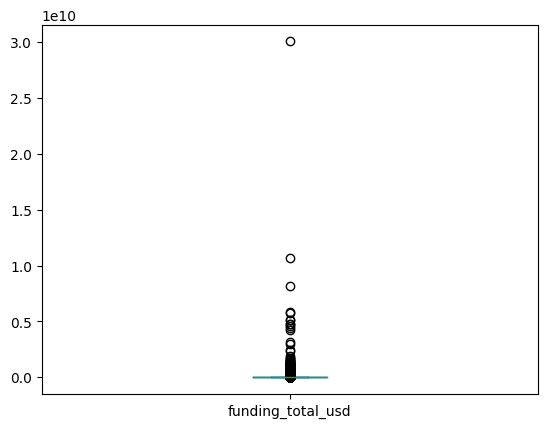

In [43]:
data_final['funding_total_usd'].plot.box()

In [44]:
data_final = data_final[data_final['funding_total_usd'] <= 7000000000]

<Axes: >

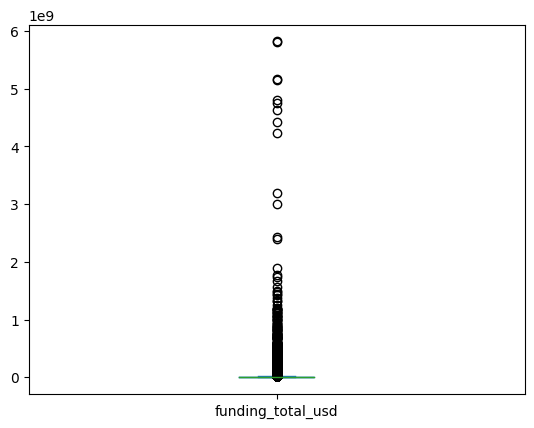

In [45]:
data_final['funding_total_usd'].plot.box()

In [46]:
def fin_cat(x):
    if x == 0:
        return 'отсутсвует'
    elif 0 < x <= 1000000:
        return 'ниже среднего'
    elif 1000000 < x <= 7000000:
        return 'среднее'
    elif 7000000 < x <= 80000000:
        return 'выше среднего'
    elif 80000000 < x <= 200000000:
        return 'высокое'
    return 'очень высокое'

In [47]:
data_final['funding_cat'] = data_final['funding_total_usd'].apply(fin_cat)
data_final = data_final.drop('funding_total_usd', axis=1)

In [48]:
data_final.drop('name', axis=1).duplicated().sum()

355

In [49]:
data_final = data_final[~data_final.drop('name', axis=1).duplicated()]

In [50]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51270 entries, 0 to 52515
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   name            51270 non-null  object
 1   status          51270 non-null  object
 2   country_code    51270 non-null  object
 3   state_code      51270 non-null  object
 4   region          51270 non-null  object
 5   city            51270 non-null  object
 6   funding_rounds  51270 non-null  int64 
 7   first_to_last   51270 non-null  int64 
 8   lifetime        51270 non-null  int64 
 9   category_first  51270 non-null  object
 10  funding_cat     51270 non-null  object
dtypes: int64(3), object(8)
memory usage: 4.7+ MB


# 3. Корреляционный анализ

/opt/conda/lib/python3.10/site-packages/phik/bivariate.py:241: UserWarning: Many cells: 4643686. Are interval variables set correctly?
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/phik/bivariate.py:241: UserWarning: Many cells: 3170424. Are interval variables set correctly?
  warnings.warn(


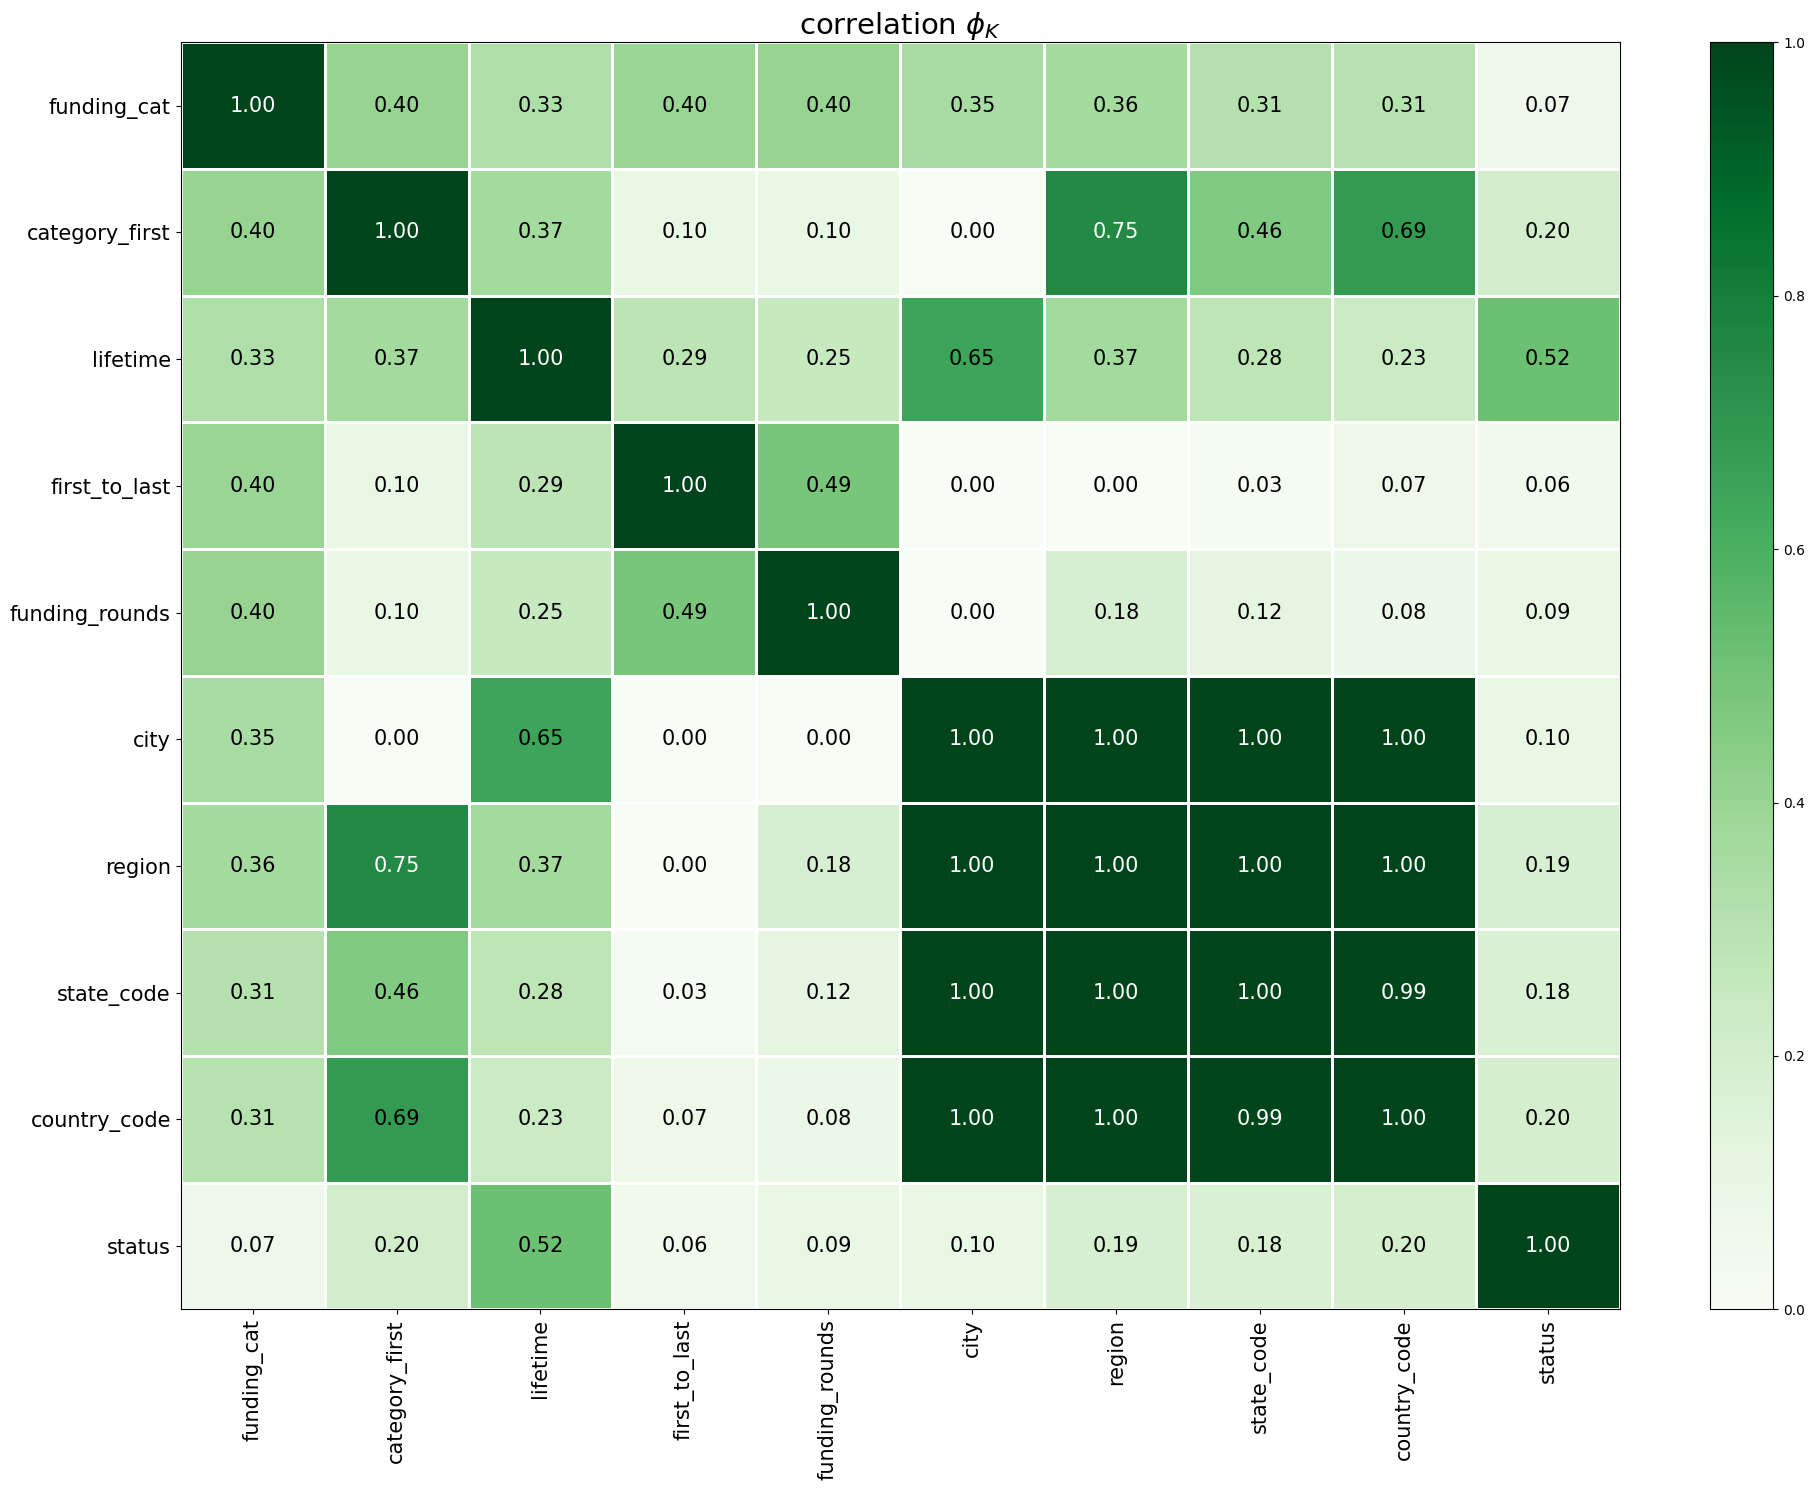

In [51]:
interval_cols=data_final.drop(['name',],axis=1).select_dtypes(include='number').columns.tolist()
phik_overview = phik_matrix(data_final.drop(['name',],axis=1), interval_cols=interval_cols) 
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Удалим признаки, которые между собой мультиколлинеарны

In [52]:
data_final = data_final.drop(['city', 'region', 'state_code'], axis=1)

In [53]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51270 entries, 0 to 52515
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   name            51270 non-null  object
 1   status          51270 non-null  object
 2   country_code    51270 non-null  object
 3   funding_rounds  51270 non-null  int64 
 4   first_to_last   51270 non-null  int64 
 5   lifetime        51270 non-null  int64 
 6   category_first  51270 non-null  object
 7   funding_cat     51270 non-null  object
dtypes: int64(3), object(5)
memory usage: 3.5+ MB


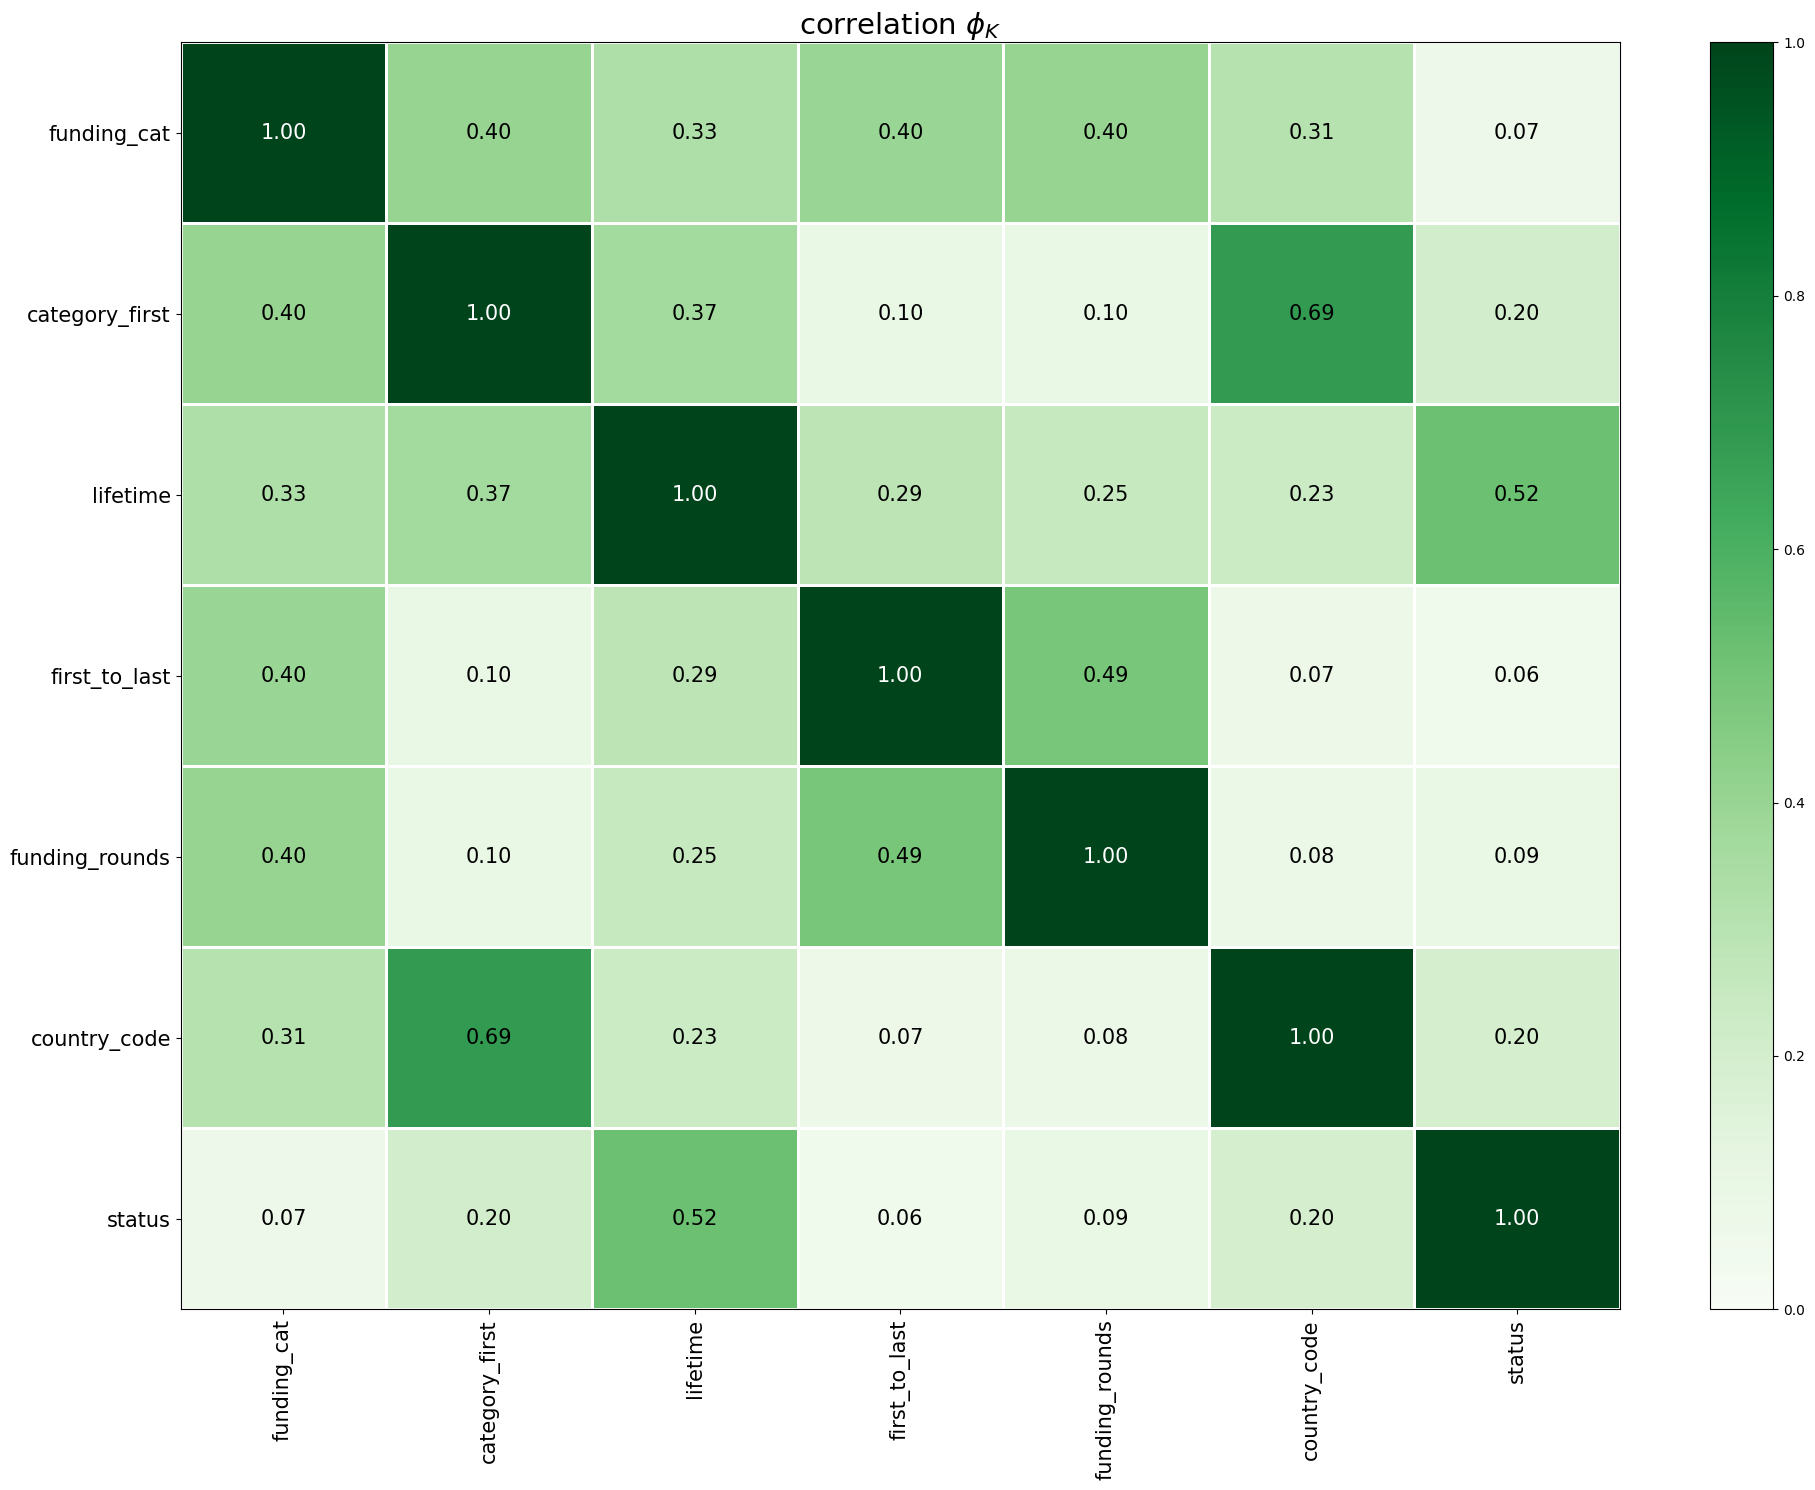

In [54]:
interval_cols=data_final.drop(['name',],axis=1).select_dtypes(include='number').columns.tolist()
phik_overview = phik_matrix(data_final.drop(['name',],axis=1), interval_cols=interval_cols) 
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

# 4. Выбор и обучение модели

In [55]:
X_train = data_final.drop(['name', 'status'], axis=1)
y_train = data_final['status']

In [56]:
cat_cols = X_train.select_dtypes(exclude='number').columns.tolist()
num_cols = X_train.select_dtypes(include='number').columns.tolist()

In [57]:
cat_cols

['country_code', 'category_first', 'funding_cat']

In [58]:
num_cols

['funding_rounds', 'first_to_last', 'lifetime']

In [59]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)


data_preprocessor = ColumnTransformer(
    [('cat', ord_pipe, cat_cols),
     ('num', MinMaxScaler(), num_cols)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [60]:
param_distributions = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 15),
        'models__metric' : ['minkowski','euclidean','manhattan'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__min_samples_split': range(2, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
] 

In [61]:
f1 = make_scorer(f1_score , average='macro')

In [62]:
grid = GridSearchCV(
    pipe_final, 
    param_grid=param_distributions, 
    cv=5, 
    scoring=f1, 
    n_jobs=-1, 
)

In [63]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('simpleImputer_before_ord',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ord',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=nan)),
                                                                                         ('simpleImputer_after_ord',
                                                                                          SimpleImputer(strategy='most_frequent'...
                          'models__n_neighbors': range(2, 15),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [DecisionTreeClassifier(class_weight='balanced',
                                                            random_state=42)],
                          'models__max_depth': range(2, 10),
                          'models__min_samples_split': range(2, 7),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring=make_scorer(f1_score, average=macro))

In [64]:
grid.best_params_

{'models': KNeighborsClassifier(metric='manhattan', n_neighbors=14),
 'models__metric': 'manhattan',
 'models__n_neighbors': 14,
 'preprocessor__num': 'passthrough'}

In [65]:
print(f'Значение метрики f1_score на тренировочной выборке лучшей модели равняется {grid.best_score_:.4f}')

Значение метрики f1_score на тренировочной выборке лучшей модели равняется 0.8203


In [66]:
data_test['funding_cat'] = data_test['funding_total_usd'].apply(fin_cat)
data_test['first_to_last'] = (data_test['last_funding_at'] - data_test['first_funding_at']).dt.days
data_test['category_first'] = data_test['category_list'].str.split('|').str[0]

In [67]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      13125 non-null  object        
 2   funding_total_usd  13125 non-null  float64       
 3   country_code       13125 non-null  object        
 4   state_code         13125 non-null  object        
 5   region             13125 non-null  object        
 6   city               13125 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
 11  funding_cat        13125 non-null  object        
 12  first_to_last      13125 non-null  int64         
 13  category_first     13125 non-null  object        
dtypes: dat

In [68]:
data_test_final = data_test.drop(['category_list', 'state_code', 'region', 'city', 'first_funding_at', 'funding_total_usd'], axis=1)

In [69]:
data_test_final['status'] = grid.best_estimator_.predict(data_test_final.drop('name',axis=1))

In [70]:
result = data_test_final[['name', 'status']]

In [71]:
result['status'].value_counts()

status
operating    12208
closed         917
Name: count, dtype: int64

In [72]:
result.to_csv('submission.csv', index=False)

# 5. Анализ важности признаков 

Для обучения модели использовались следующие признаки: 'country_code', 'category_first', 'funding_cat', 'funding_rounds', 'first_to_last', 'lifetime'.

# 6. Выводы

В ходе проекта были загружены необходимые данные. В обучающих данных были удалены пропуски и неявные дубликаты, созданы новые синтетические признаки (первая категория, финансовая категория, время в днях от первого раунда финансирования до последнего, время существования стартапа в днях). Удалены из обучения признаки funding_total_usd, founded_at, first_funding_at, last_funding_at, closed_at, а также географические признаки кроме страны (мультиколлинеарность).

Лучшая модель:{'models': KNeighborsClassifier(metric='manhattan', n_neighbors=14).

Значение метрики f1_score на тренировочной выборке лучшей модели равняется 0.8203.

Для обучения модели использовались следующие признаки: 'country_code', 'category_first', 'funding_cat', 'funding_rounds', 'first_to_last', 'lifetime'.

В этой связи для улучшения прогнозирования успешности стартапа предлагается указывать страну, более четко составить классификацию категорий, уйти от указания точной суммы финансирования к разработанной классификации размера финансирования.
